In [12]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import konlpy
from konlpy.tag import Okt
from keras.layers import Embedding, Dense, LSTM, Activation
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import re

In [13]:
df = pd.read_excel("test_all3.xlsx")

In [14]:
df.head()

,content,countryEnName,countryName,fileUrl,id,title,wrtDt,Div
0,"&nbsp;&nbsp;미국, 입국 전 14일 이상 브라질 체류한 모든 외국인 입국 ...",United States of America,미국,NaN,ATC0000000007885,미국 입국 전 14일 이상 브라질 체류한 모든 외국인 입국 규제 관련 안내,2020-05-27,정보
1,홍콩 시위 관련 안전공지1. 현재 홍콩에서 보안법 이슈 쟁점화로 시위 빈도 및 강도...,hongkong,홍콩(중국),NaN,ATC0000000007884,홍콩 시위 관련 안전공지(5.26),2020-05-26,치안
2,ㅇ 열대성 폭풍 Manga가 5.24.(일)~5.25.(월) 호두 대륙을 통과할 예...,Australia,호주,NaN,ATC0000000007881,호주 열대성 폭풍 Manga 관련 안전 공지,2020-05-23,자연재해
3,태국 뎅기열 유행에 따른 유의사항 안내&nbsp;○ 최근 태국 동북부 지역에서 뎅기...,Thailand,태국,NaN,ATC0000000007857,태국 뎅기열 유행에 따른 유의사항,2020-05-19,질병
4,‘우리 기업인 대상’ 헝가리 입국 허용 관련 안내&nbsp;○ 헝가리 정부는 4.3...,Hungary,헝가리,http://www.0404.go.kr/dev/fileDownload.mofa?at...,ATC0000000007855,‘우리 기업인 대상’ 헝가리 입국 허용 관련 안내,2020-05-19,정보


In [15]:
len(df)

5574

In [16]:
# df = df.dropna(how='any', subset=['Div'])
# print(len(df))

In [17]:
df['Content'] = df.apply(lambda x: np.nan if pd.isnull(x['title']) and pd.isnull(x['content']) else x['title'] if pd.isnull(x['content']) else x['title'] + ' ' + x['content'] , axis=1)

In [7]:
# df = df[['Content','Div']]

In [18]:
df.head()

,content,countryEnName,countryName,fileUrl,id,title,wrtDt,Div,Content
0,"&nbsp;&nbsp;미국, 입국 전 14일 이상 브라질 체류한 모든 외국인 입국 ...",United States of America,미국,NaN,ATC0000000007885,미국 입국 전 14일 이상 브라질 체류한 모든 외국인 입국 규제 관련 안내,2020-05-27,정보,미국 입국 전 14일 이상 브라질 체류한 모든 외국인 입국 규제 관련 안내 &nbs...
1,홍콩 시위 관련 안전공지1. 현재 홍콩에서 보안법 이슈 쟁점화로 시위 빈도 및 강도...,hongkong,홍콩(중국),NaN,ATC0000000007884,홍콩 시위 관련 안전공지(5.26),2020-05-26,치안,홍콩 시위 관련 안전공지(5.26) 홍콩 시위 관련 안전공지1. 현재 홍콩에서 보안...
2,ㅇ 열대성 폭풍 Manga가 5.24.(일)~5.25.(월) 호두 대륙을 통과할 예...,Australia,호주,NaN,ATC0000000007881,호주 열대성 폭풍 Manga 관련 안전 공지,2020-05-23,자연재해,호주 열대성 폭풍 Manga 관련 안전 공지 ㅇ 열대성 폭풍 Manga가 5.24....
3,태국 뎅기열 유행에 따른 유의사항 안내&nbsp;○ 최근 태국 동북부 지역에서 뎅기...,Thailand,태국,NaN,ATC0000000007857,태국 뎅기열 유행에 따른 유의사항,2020-05-19,질병,태국 뎅기열 유행에 따른 유의사항 태국 뎅기열 유행에 따른 유의사항 안내&nbsp;...
4,‘우리 기업인 대상’ 헝가리 입국 허용 관련 안내&nbsp;○ 헝가리 정부는 4.3...,Hungary,헝가리,http://www.0404.go.kr/dev/fileDownload.mofa?at...,ATC0000000007855,‘우리 기업인 대상’ 헝가리 입국 허용 관련 안내,2020-05-19,정보,‘우리 기업인 대상’ 헝가리 입국 허용 관련 안내 ‘우리 기업인 대상’ 헝가리 입국...


In [19]:
from konlpy.tag import Okt

stopwords = ['콜센터', '등', '및', '번호', '전', '하다', '하여', '월', '화', '수', '목', '금', '토', '일']

X = []
okt = Okt()

for i in range(len(df)):
    _x = df.iloc[i]['Content']
    
    okt_morphs = okt.pos(_x)  # 튜플반환
    temp_x = []
    for word, pos in okt_morphs:
        if pos == 'Noun' or pos == 'Verb':
            temp_x.append(word)
            
    temp_x = [word for word in temp_x if not word in stopwords]
    X.append(temp_x)
    

max_words = 35000
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

제목의 최대 길이 :  1728
제목의 평균 길이 :  119.44581987800503


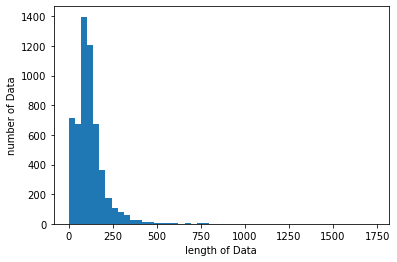

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

print("제목의 최대 길이 : ", max(len(l) for l in X))
print("제목의 평균 길이 : ", sum(map(len, X))/ len(X))
plt.hist([len(s) for s in X], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

In [21]:
dic = {
    '정보': 0,
    '자연재해': 1,
    '질병': 2,
    '치안': 3
}
df['div'] = df['Div'].apply(lambda x: dic[x] if pd.notnull(x) else np.nan)
# Y = to_categorical(df['Div'])

In [13]:
# x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [22]:
from keras.layers import Embedding, Dense, LSTM
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences

# max_len = max(len(l) for l in X) # 전체 데이터의 길이를 20로 맞춘다
max_len = 1728
X = pad_sequences(X, maxlen=max_len)

In [23]:
# loading model
from keras.models import model_from_json

model = model_from_json(open('model_architecture.json').read())
model.load_weights('model_weights.h5')

# dont forget to compile your model

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# score = model.evaluate(X, Y, verbose=0)

In [29]:
score

[0.045781337794683435, 0.9916911721229553]

In [30]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         3500000   
_________________________________________________________________
lstm_7 (LSTM)                (None, None, 50)          30200     
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 204       
_________________________________________________________________
activation_4 (Activation)    (None, 4)                 0         
Total params: 3,550,604
Trainable params: 3,550,604
Non-trainable params: 0
_________________________________________________________________


In [24]:
y_pred = model.predict_classes(X, verbose=1)

5574/5574 [==============================] - 71s 13ms/step


In [43]:
row_maxes = Y.argmax(axis=1)
row_maxes

array([0, 3, 1, ..., 3, 3, 3], dtype=int64)

In [25]:
y_pred

array([3, 3, 3, ..., 0, 0, 0], dtype=int64)

In [44]:
len(row_maxes)

3400

In [45]:
len(y_pred)

3400

In [46]:
count = 0
for i in range(len(y_pred)):
    if row_maxes[i] != y_pred[i]:
        count+=1

In [47]:
count

57

In [26]:
df['pred_Div'] = y_pred

In [29]:
df['Equal'] = (df['div']==df['pred_Div'])

In [30]:
df['Equal'].value_counts()

False    3325
True     2249
Name: Equal, dtype: int64

In [33]:
df2 = pd.read_excel("test_all3.xlsx")

In [34]:
df2 = df.dropna(how='any', subset=['Div'])
print(len(df2))

3583


In [35]:
df2['Content'] = df2.apply(lambda x: np.nan if pd.isnull(x['title']) and pd.isnull(x['content']) else x['title'] if pd.isnull(x['content']) else x['title'] + ' ' + x['content'] , axis=1)

C:\Users\min-sung.lee\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [37]:
from konlpy.tag import Okt

stopwords = ['콜센터', '등', '및', '번호', '전', '하다', '하여', '월', '화', '수', '목', '금', '토', '일']

X = []
okt = Okt()

for i in range(len(df2)):
    _x = df2.iloc[i]['Content']
    
    okt_morphs = okt.pos(_x)  # 튜플반환
    temp_x = []
    for word, pos in okt_morphs:
        if pos == 'Noun' or pos == 'Verb':
            temp_x.append(word)
            
    temp_x = [word for word in temp_x if not word in stopwords]
    X.append(temp_x)
    

max_words = 35000
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

In [39]:
dic = {
    '정보': 0,
    '자연재해': 1,
    '질병': 2,
    '치안': 3
}
df2['div'] = df2['Div'].apply(lambda x: dic[x] if pd.notnull(x) else np.nan)
Y = to_categorical(df2['div'])

C:\Users\min-sung.lee\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [40]:
from keras.layers import Embedding, Dense, LSTM
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences

# max_len = max(len(l) for l in X) # 전체 데이터의 길이를 20로 맞춘다
max_len = 1728
X = pad_sequences(X, maxlen=max_len)

In [47]:
# loading model
from keras.models import model_from_json
from keras import optimizers

model = model_from_json(open('model_architecture.json').read())
model.load_weights('model_weights.h5')

# dont forget to compile your model

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr = 0.001), metrics=['accuracy'])

score = model.evaluate(X, Y, verbose=1)

3583/3583 [==============================] - 46s 13ms/step


In [77]:
model.model['accuracy']

C:\Users\min-sung.lee\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


TypeError: 'Sequential' object is not subscriptable

In [74]:
score

[1.363561906371611, 0.8101451396942139]

In [71]:
Y

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [49]:
y_pred_ = model.predict(X, verbose=1)

ValueError: `axis` must be fewer than the number of dimensions (1)

In [57]:
y_pred_

array([[2.3530187e-05, 1.2960217e-04, 7.4565993e-05, 9.9977225e-01],
       [2.7260141e-05, 1.2955681e-04, 7.3832336e-05, 9.9976939e-01],
       [3.6641143e-02, 2.4090162e-02, 9.3816805e-01, 1.1005460e-03],
       ...,
       [2.8912255e-01, 5.4362535e-02, 2.4620934e-01, 4.1030556e-01],
       [8.2024330e-01, 6.1929308e-02, 6.4272970e-02, 5.3554323e-02],
       [4.0017867e-01, 2.0145211e-02, 5.5721349e-01, 2.2462619e-02]],
      dtype=float32)

In [58]:
row_maxes = y_pred_.argmax(axis=1)
row_maxes

array([3, 3, 2, ..., 3, 0, 2], dtype=int64)

In [69]:
y_test_ = np.argmax(df2['div'].tolist(), axis=1)
y_test_

AxisError: axis 1 is out of bounds for array of dimension 1

In [73]:
# y_test_ = np.argmax(df2['div'], axis=1)
print(accuracy_score(row_maxes, df2['div']))

0.6181970415852638


In [ ]:
print(accuracy_score(row_maxes, df2['div']))

In [ ]:
y_test_ = np.argmax(df2['div'], axis = 1)
print(accuracy_score(y_pred_, y_test_))

In [52]:
y_test_ = np.argmax(df2['div'].tolist(), axis = 1)
print(accuracy_score(y_pred_, y_test_))

AxisError: axis 1 is out of bounds for array of dimension 1

In [43]:
y_pred = model.predict_classes(X, verbose=1)

3583/3583 [==============================] - 46s 13ms/step


In [44]:
df2['pred_Div'] = y_pred

C:\Users\min-sung.lee\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [45]:
df2['Equal'] = (df2['div']==df2['pred_Div'])

C:\Users\min-sung.lee\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [46]:
df2['Equal'].value_counts()

True     2215
False    1368
Name: Equal, dtype: int64

In [32]:
df2['Equal'].value_counts()

True     2249
False    1334
Name: Equal, dtype: int64

In [33]:
dic = {
    0: '정보',
    1: '자연재해',
    2: '질병',
    3: '치안'
}
l = []
for i in range(len(y_pred)):
    l.append(dic[y_pred[i]])
l

['정보',
 '치안',
 '자연재해',
 '질병',
 '정보',
 '정보',
 '정보',
 '정보',
 '정보',
 '정보',
 '정보',
 '자연재해',
 '질병',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '질병',
 '질병',
 '질병',
 '정보',
 '질병',
 '질병',
 '질병',
 '질병',
 '질병',
 '정보',
 '정보',
 '치안',
 '정보',
 '정보',
 '질병',
 '정보',
 '질병',
 '질병',
 '정보',
 '질병',
 '질병',
 '질병',
 '질병',
 '정보',
 '치안',
 '치안',
 '질병',
 '치안',
 '치안',
 '질병',
 '질병',
 '정보',
 '질병',
 '정보',
 '질병',
 '정보',
 '치안',
 '치안',
 '정보',
 '정보',
 '정보',
 '정보',
 '질병',
 '질병',
 '자연재해',
 '질병',
 '질병',
 '질병',
 '질병',
 '치안',
 '질병',
 '질병',
 '질병',
 '질병',
 '질병',
 '치안',
 '치안',
 '질병',
 '질병',
 '질병',
 '질병',
 '질병',
 '치안',
 '질병',
 '질병',
 '질병',
 '치안',
 '치안',
 '질병',
 '자연재해',
 '치안',
 '질병',
 '치안',
 '질병',
 '정보',
 '질병',
 '질병',
 '정보',
 '질병',
 '질병',
 '질병',
 '치안',
 '질병',
 '치안',
 '질병',
 '질병',
 '치안',
 '질병',
 '질병',
 '자연재해',
 '질병',
 '자연재해',
 '정보',
 '질병',
 '질병',
 '질병',
 '질병',
 '정보',
 '치안',
 '자연재해',
 '치안',
 '치안',
 '치안',
 '치안',
 '질병',
 '질병',
 '자연재해',
 '치안',
 '치안',
 '정보',
 '치안',
 '치안',
 '치안',
 '치안',
 '치안',
 '자연재해',
 '정보',
 '치안',
 '치안',
 '치안',
 '

In [38]:
div_df = pd.DataFrame(y_pred, columns =['pred_Div'])
df['pred_Div'] = div_df['pred_Div']
df = df[['Div', 'pred_Div']]
df['Equal'] = (df['Div']==df['pred_Div'])

In [39]:
df.to_excel("result_temp.xlsx", index=False)